In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end],series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
# Trend
def trend(time, slope=0):
    return slope*time

In [4]:
# Seasonality
# For aribitary pattern
def seasonal_pattern(season_time):
    return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

In [5]:
# Repeats the same pattern at each period
def seasonality(time, period, amplitude=1, phase=0):
    season_time=((time+phase) % period)/period
    return amplitude*seasonal_pattern(season_time)

In [6]:
#Noise
def noise(time, noise_level=1, seed=None):
    rnd=np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

In [7]:
# Defining time
time =np.arange(4*365+1, dtype="float32")

In [9]:
#Explicitly mentioning the parameters
baseline=10
series=trend(time, 0.1)
baseline=10
amplitude=40
slope=0.05
noise_level=5



In [10]:
#Create the series
series=baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

In [12]:
#Adding noise
series+=noise(time, noise_level, seed=42)

In [11]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time, series)
plt.show()

In [13]:
#Training and validation sets
split_time =1000
time_train=time[:split_time]
series_train=series[:split_time]
time_valid=time[split_time:]
series_valid=series[split_time:]

In [ ]:
plt.figure(figsize=(10,6))
plot_series(time_train, series_train)
plt.title("Training Set")
plt.show()

plt.figure(figsize=(10,6))
plot_series(time_valid, series_valid)
plt.title("Validation Set")
plt.show()

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [15]:
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[-0.03811226],
       [-0.03387527],
       [ 0.07057929],
       [ 0.01344058],
       [ 0.0059241 ],
       [-0.01739214],
       [ 0.03865141],
       [-0.05765781],
       [ 0.01747132],
       [ 0.06081578],
       [-0.02282567],
       [-0.03493696],
       [-0.03519379],
       [ 0.02735219],
       [ 0.12246979],
       [ 0.03703092],
       [-0.02794302],
       [ 0.1427008 ],
       [ 0.27096176],
       [ 0.49185473]], dtype=float32), array([0.01230078], dtype=float32)]


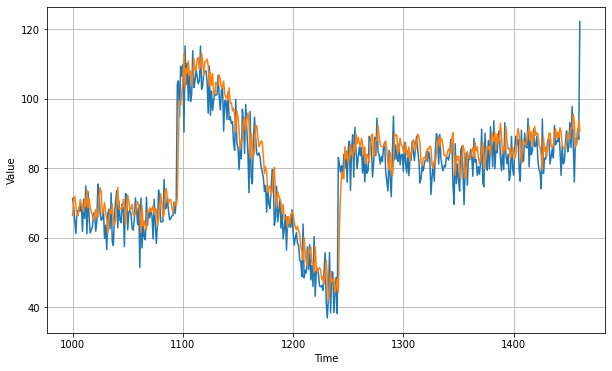

In [16]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
#To get all the rows and 1st element of the 1st column
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, results)

In [22]:
print(tf.keras.metrics.mean_squared_error(series_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(series_valid, results).numpy())

51.73717
5.5933995


In [ ]:
#3 layer DNN and HYperparameter tuning

In [23]:
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)


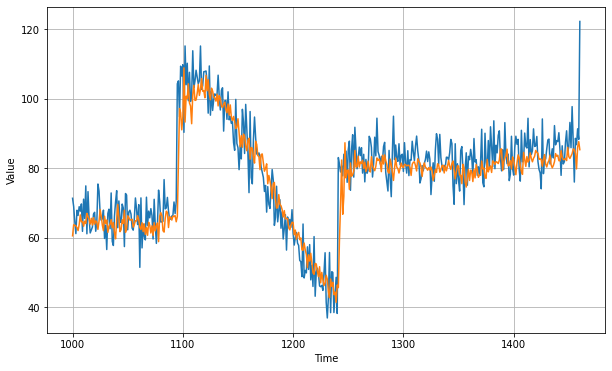

In [24]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, results)

In [26]:
tf.keras.metrics.mean_absolute_error(series_valid, results).numpy()

5.2939787

In [27]:
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

(1e-08, 0.001, 0.0, 300.0)

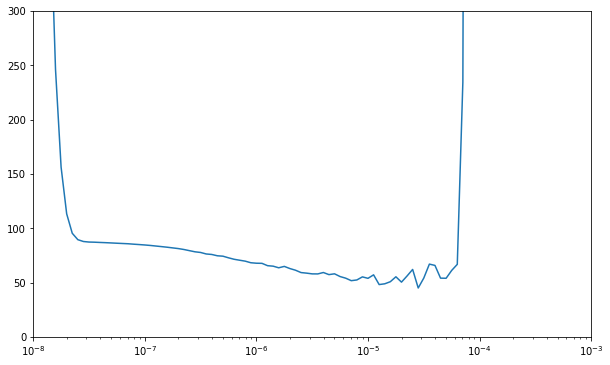

In [29]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.figure(figsize=(10,6))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [31]:
window_size = 30
dataset = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

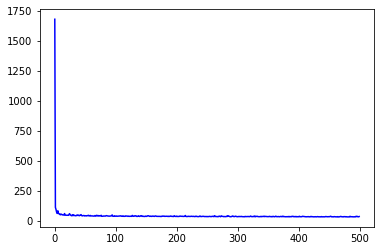

In [32]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[54.29168561955088, 54.204371257664, 48.41759317928983, 49.10683155649716, 48.167334672593576, 46.95334572546261, 59.502033477468586, 46.308836494524456, 46.370345782250475, 45.96429413864293, 45.23447113037109, 46.10763079456447, 45.20751047822618, 46.017618663040636, 58.84401533382455, 52.907084954645214, 46.14977525534089, 42.721305593510266, 41.46852903071138, 49.6428574394934, 42.14797057318933, 48.12486851879002, 43.371488858252455, 42.95068478141863, 41.587218868609554, 41.518637450699956, 46.262836015838936, 43.90352996747518, 48.03079307005577, 44.24743221322286, 41.27902686915447, 45.1796642972022, 44.3846773757148, 50.88221862635662, 42.92354931388934, 40.09166741911898, 42.35682966094656, 43.22392477448454, 43.16097920604588, 39.512582680613725, 41.03335395105106, 41.55539581456135, 39.88590048170581, 41.99735969464803, 42.17367380673124, 45.21046003361338, 40.85577265945906, 39.97352025140192, 43.894678560237296, 40.18295329084101, 40.31958681086904, 39.67109621972153, 39.

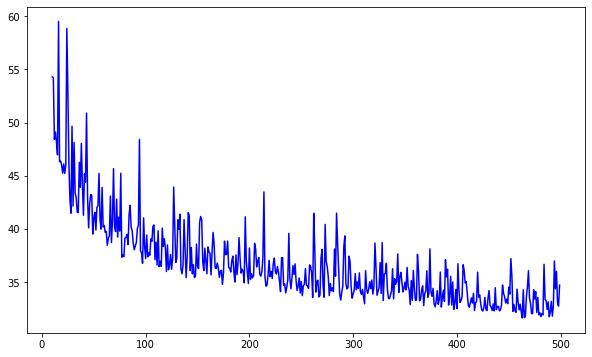

In [40]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)


plt.figure(figsize=(10,6))
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

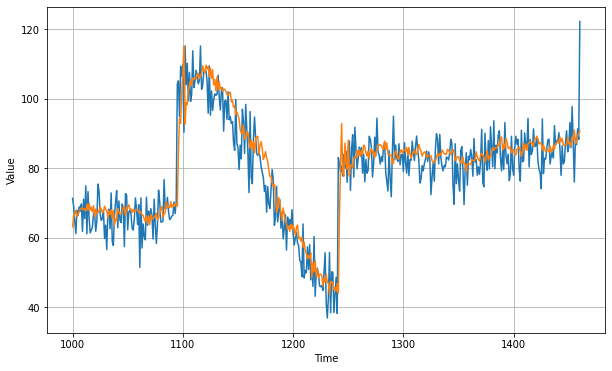

In [37]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, results)

In [38]:
tf.keras.metrics.mean_absolute_error(series_valid, results).numpy()

5.017862